# Instalacja pakietów

In [1]:
!pip install transformers datasets torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Załadowanie pakietów

In [2]:
from datasets import load_dataset
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random

# Załadowanie datasetu
sms_spam

In [3]:
dataset = load_dataset("sms_spam")

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

Dataset sms_spam downloaded and prepared to /root/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
dataset['train'][0]

{'sms': 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n',
 'label': 0}

# Tokenizer BERT

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
sms = dataset['train'][0]['sms']
print('Original: ', sms)
print('Tokenized: ', tokenizer.tokenize(sms))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sms)))

Original:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Tokenized:  ['go', 'until', 'ju', '##rong', 'point', ',', 'crazy', '.', '.', 'available', 'only', 'in', 'bug', '##is', 'n', 'great', 'world', 'la', 'e', 'buffet', '.', '.', '.', 'ci', '##ne', 'there', 'got', 'amore', 'wat', '.', '.', '.']
Token IDs:  [2175, 2127, 18414, 17583, 2391, 1010, 4689, 1012, 1012, 2800, 2069, 1999, 11829, 2483, 1050, 2307, 2088, 2474, 1041, 28305, 1012, 1012, 1012, 25022, 2638, 2045, 2288, 26297, 28194, 1012, 1012, 1012]


# Check maximum length of a sentence

In [7]:
max_len = 0

for sentence in dataset['train']:
    input_ids = tokenizer.encode(sentence['sms'], add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  238


# Special tokenization

In [8]:
input_ids = []
attention_masks = []

for sentence in dataset['train']:
    encoded_dict = tokenizer.encode_plus(
                        sentence['sms'],
                        add_special_tokens = True,
                        max_length = 240,
                        padding = 'max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor([sentence['label'] for sentence in dataset['train']])

print('Original: ', dataset['train'][0])
print('Token IDs:', input_ids[0])

Original:  {'sms': 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n', 'label': 0}
Token IDs: tensor([  101,  2175,  2127, 18414, 17583,  2391,  1010,  4689,  1012,  1012,
         2800,  2069,  1999, 11829,  2483,  1050,  2307,  2088,  2474,  1041,
        28305,  1012,  1012,  1012, 25022,  2638,  2045,  2288, 26297, 28194,
         1012,  1012,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     

# Split dataset
Class balance ratio should be similar to base dataset ratio.

In [16]:
def check_class_balance(dataset):
  spam_count = 0.0
  not_spam_count = 0.0
  for row in dataset:
    if row[2].item() == 1:
      spam_count += 1.0
    else:
      not_spam_count += 1.0
  return spam_count / not_spam_count 

In [23]:
dataset = TensorDataset(input_ids, attention_masks, labels)
print("Spam to not spam messages ratio: {}\n".format(check_class_balance(dataset)))

test_size = 1000
dataset_len = len(dataset)
train_size = int(0.9 * (dataset_len-test_size))
val_size = (dataset_len-test_size) - train_size

test_dataset, train_dataset, val_dataset = random_split(dataset, [test_size, train_size, val_size])

print('{:>5,} test samples'.format(test_size))
print("Ratio: {}\n".format(check_class_balance(test_dataset)))
print('{:>5,} training samples'.format(train_size))
print("Ratio: {}\n".format(check_class_balance(train_dataset)))
print('{:>5,} validation samples'.format(val_size))
print("Ratio: {}\n".format(check_class_balance(val_dataset)))

Spam to not spam messages ratio: 0.15475450590428838

1,000 test samples
Ratio: 0.1792452830188679

4,116 training samples
Ratio: 0.15100671140939598

  458 validation samples
Ratio: 0.13647642679900746



# Create train and validation loaders

In [24]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

# Device check

In [25]:
if torch.cuda.is_available():    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Custom BERT for classification
Compared to default BertForSequenceClassification - additional linear layer.
https://github.com/huggingface/transformers/blob/bd469c40659ce76c81f69c7726759d249b4aef49/src/transformers/models/bert/modeling_bert.py#L1506

In [27]:
from transformers import BertForSequenceClassification, BertConfig, BertModel
from torch import nn

In [28]:
# in original model - no custom head just linear layer
# self.classifier = nn.Linear(config.hidden_size, config.num_labels)

class BertClassificationHeadCustom(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config.hidden_size, config.hidden_size)
        self.dense_2 = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, x):
        x = self.dense_1(x)
        x = torch.relu(x)

        x = self.dense_2(x)
        x = torch.relu(x)
        return x


class BertForSequenceClassificationCustom(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = BertClassificationHeadCustom(config)

        # Initialize weights and apply final processing
        self.post_init()



model = BertForSequenceClassificationCustom.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassificationCustom: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassificationCustom from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassificationCustom from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificationCustom were not initialized from

BertForSequenceClassificationCustom(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

# Init training parameters

In [29]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Helper functions

In [30]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training

In [31]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        loss = outputs['loss']
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs['loss']
            logits = outputs['logits']
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    129.    Elapsed: 0:00:48.
  Batch    80  of    129.    Elapsed: 0:01:35.
  Batch   120  of    129.    Elapsed: 0:02:23.

  Average training loss: 0.13
  Training epcoh took: 0:02:34

Running Validation...
  Accuracy: 0.98
  Validation Loss: 0.08
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    129.    Elapsed: 0:00:49.
  Batch    80  of    129.    Elapsed: 0:01:38.
  Batch   120  of    129.    Elapsed: 0:02:27.

  Average training loss: 0.03
  Training epcoh took: 0:02:38

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.06
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    129.    Elapsed: 0:00:49.
  Batch    80  of    129.    Elapsed: 0:01:37.
  Batch   120  of    129.    Elapsed: 0:02:26.

  Average training loss: 0.01
  Training epcoh took: 0:02:37

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.06
  Validation too

# Train summary

In [32]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')
df_stats

Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1           1.26e-01         0.08           0.98       0:02:34         0:00:06
2           2.58e-02         0.06           0.99       0:02:38         0:00:06
3           1.26e-02         0.06           0.99       0:02:37         0:00:06
4           9.73e-03         0.06           0.99       0:02:36         0:00:06

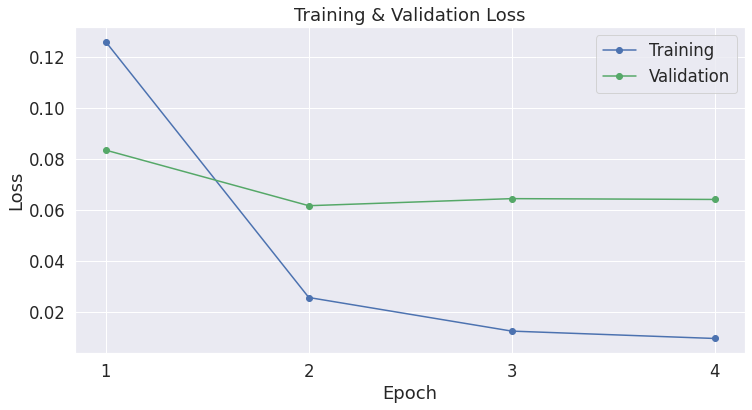

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Create test loader

In [34]:
prediction_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

# Evaluate on test dataset

In [35]:
print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs['logits']

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,000 test sentences...
    DONE.


In [36]:
results_ok = 0
results_false = 0
for idx, true_labels_batch in enumerate(true_labels):
  predictions_i = np.argmax(predictions[idx], axis=1).flatten()
  for bidx, true_label in enumerate(true_labels_batch):
    if true_label == predictions_i[bidx]:
      results_ok += 1
    else:
      results_false += 1

print("Correct predictions: {}, incorrect results: {}, accuracy: {}".format(results_ok, results_false, float(results_ok) / (results_ok + results_false)))

Correct predictions: 995, incorrect results: 5, accuracy: 0.995


# MCC Score

In [37]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


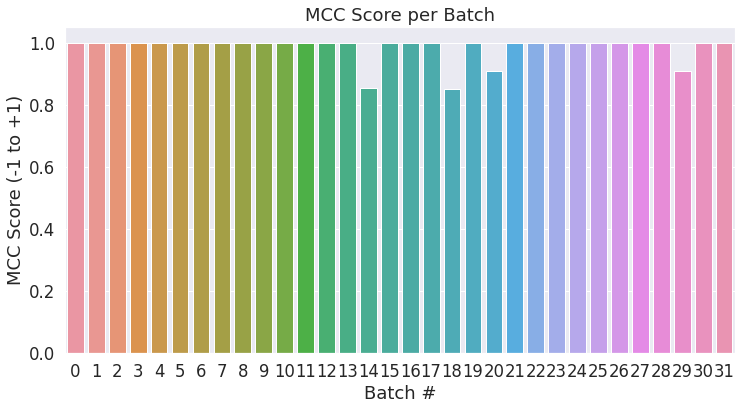

In [38]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [39]:
flat_predictions = np.concatenate(predictions, axis=0)

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.981


# Save model

In [40]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

output_dir = '/content/gdrive/My Drive/UAM/Przetwarzanie-tekstu/BERT_custom_model'
print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Mounted at /content/gdrive/
Saving model to /content/gdrive/My Drive/UAM/Przetwarzanie-tekstu/BERT_custom_model


('/content/gdrive/My Drive/UAM/Przetwarzanie-tekstu/BERT_custom_model/tokenizer_config.json',
 '/content/gdrive/My Drive/UAM/Przetwarzanie-tekstu/BERT_custom_model/special_tokens_map.json',
 '/content/gdrive/My Drive/UAM/Przetwarzanie-tekstu/BERT_custom_model/vocab.txt',
 '/content/gdrive/My Drive/UAM/Przetwarzanie-tekstu/BERT_custom_model/added_tokens.json')

# Bibliografia
https://mccormickml.com/2019/07/22/BERT-fine-tuning/#a1-saving--loading-fine-tuned-model